# [Weather data and solar radiation](../t01/t01ReadWeatherData.ipynb)

# [Simple wall](../t02/t02SimpleWall.ipynb)

# From thermal circuit to state-space representation

Objectives:
- Physical analysis of a cubic building with 5 identical walls & a transparent wall (glass window), air infiltration, and HVAC system.
- Thermal circuit modelling of the building.
- Mathematical modelling as a system of Differential Algebraic Equations (DAE) and state-space representation.
- Steady-state and dynamic simulation.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import dm4bem

## Physical analysis and mathematical modelling

### Description of the building

![cube](./figures/t03_cube_principle.png)
> Figure 1. Simple ventilated room (5 walls and 1 glass window) equiped with an HVAC system which acts as a proportional controller.

Let’s consider a cubic building with an HVAC systems acting as a [proportional controller](https://en.m.wikipedia.org/wiki/Proportional_control).

The dimensions and surface areas of the building are:
- $l=3 \: \mathrm{m}$ - edge length of the cube;
- $S_g=l^2$   - surface area of the glass window;
- $S_c = S_i = 5 \times S_g$   - surface area of the 5 (concrete and insulation) walls.

In [2]:
l = 3               # m length of the cubic room
Sg = l**2           # m² surface of the glass wall
Sc = Si = 5 * Sg    # m² surface of concrete & insulation of the 5 walls

### Thermo-physical properties
The thermophysical properties of the air (in SI units) are:

In [3]:
air = {'Density': 1.2,                      # kg/m³
       'Specific heat': 1000}               # J/kg.K
# pd.DataFrame.from_dict(air, orient='index', columns=['air'])
pd.DataFrame(air, index=['Air'])

,Density,Specific heat
Air,1.2,1000


The [thermophysical properties](https://energieplus-lesite.be/donnees/enveloppe44/enveloppe2/conductivite-thermique-des-materiaux/) and the surface areas of the three materials (i.e., concrete, insulation, glass) in SI units are:

In [4]:
wall = {'Conductivity': [1.4, 0.027, 1.4],  # W/m.K
        'Density': [2300, 55, 2500],        # kg/m³
        'Specific heat': [880, 1210, 750],  # J/kg.K
        'Width': [0.2, 0.08, 0.004],
        'Surface': [5 * l**2, 5 * l**2, l**2],  # m²
        'Slices': [1, 1, 1]}                # number of  slices
wall = pd.DataFrame(wall, index=['Concrete', 'Insulation', 'Glass'])
wall

,Conductivity,Density,Specific heat,Width,Surface,Slices
Concrete,1.400,2300,880,0.200,45,1
Insulation,0.027,55,1210,0.080,45,1
Glass,1.400,2500,750,0.004,9,1


where `Slices` is the number of meshes used in discretization. 

The [radiative properties](https://en.wikipedia.org/wiki/Emissivity#Absorptivity) of the surfaces:
- long wave [emmisivity](https://www.engineeringtoolbox.com/emissivity-coefficients-d_447.html) of concrete (betwen normal and rough) and glass pyrex;
- short wave [absortivity of solar radiation](https://www.engineeringtoolbox.com/solar-radiation-absorbed-materials-d_1568.html) by white smooth surfaces;
- short wave [transmittance](https://www.engineeringtoolbox.com/optical-properties-glazing-materials-d_1355.html) of window glass (thickness of 4 mm);
- short wave [absortivity and transmittance](https://energieplus-lesite.be/techniques/enveloppe7/composants-de-l-enveloppe/vitrages/vitrage-permettant-le-controle-solaire/) of reflective blue window glass.

In [5]:
ε_wLW = 0.85    # long wave emmisivity wall concrete
ε_gLW = 0.90    # long wave emmisivity glass pyrex
α_wSW = 0.25    # short wave absortivity white smooth surface
α_gSW = 0.38    # short wave absortivity reflective blue glass
τ_gSW = 0.30    # short wave transmitance reflective blue glass

The [Stefan-Boltzmann constant](https://en.m.wikipedia.org/wiki/Stefan–Boltzmann_constant) is:

In [6]:
σ = 5.67e-8     # W/m²⋅K⁴ Stefan-Bolzmann constant
print(f'σ = {σ} W/m²⋅K⁴')

σ = 5.67e-08 W/m²⋅K⁴


The [view factor](https://en.m.wikipedia.org/wiki/View_factor) between the wall and the glass window is:

In [7]:
Fwg = 1 / 5     # view factor wall - glass
Fwg

0.2


Conventional values for the [convection coeficients](https://energieplus-lesite.be/theories/enveloppe9/echanges-chaleur-parois/resistance-thermique-d-echange-superficiel/) for indoor and outdoor convection in W/(m²⋅K) are:

In [8]:
h = pd.DataFrame([{'in': 8., 'out': 25}], index=['h'])  # W/m²⋅K
h

,in,out
h,8.0,25


## Thermal circuit

Heat transfert is:
- through the walls (concrete and insulation), 
- through the glass window,
- by ventilation,
- from indoor auxiliary sources,
- from the HVAC system.

The HVAC system is modelled as a proportional controller. There is long wave radiative exchange between the wall and the glass window. Sources are:
- temperature sources:
    - outdoor atmospheric air;
    - indoor set point;
- flow rate sources:
    - solar radiation on the outdoor and the indoor walls;
    - auxiliary heat gains in the thermal zone.

![heat_processes](./figures/t03_heat_process.png)
> Figure 2. Heat processes for the cubic building shown in Figure 1.

![thermal_circuit](./figures/t03_therm_circ.png)
> Figure 3. Thermal circuit for the cubic building shown in Figure 1 and the heat processes shown in Figure 2. *Note*: space discretization of the walls is done for simplicity.

Figure 3 shows the models of:
- concrete & insulation wall: in red;
- glass window: in green;
- ventilation: in magenta;
- indoor volume: in blue (conductances 6 & 7 for convection; conductance 5 for long wave radiation between the walls and the glass window);
- HVAC system: in black.

The sources are:
- $T_o$ - outdoor temperature, °C;
- $T_{i,sp}$ - set-point temperaure for the indoor air, °C;
- $\Phi_o$ - solar radiation absorbed by the outdoor surface of the wall, W;
- $\Phi_i$ - solar radiation absorbed by the indoor surface of the wall, W;
- $\dot{Q}_a$ - auxiliary heat gains (i.e., occupants, electrical devices, etc.), W;
- $\Phi_a$ - solar radiation absorbed by the glass, W.


*Note*: The known values, i.e. the elements of the circuit (the conductances $G$ and capacities $C$) and the sources (of temperature $T$ and of flow rate $\Phi$ or $\dot{Q}$) are noted in uppercase (capital) letters. The unknows variables, i.e. the temperatures in the nodes $\theta$ and the flow rates on the branches $q$, are in lowercase letters.

### Thermal coductances
#### Conduction
The conductances 1, 2, 3, and 4 of the thermal circuit from Figure 3 model the heat transfer by conduction. Conduction conductances, in W/K, are of the form:
$$G_{cd} = \frac{\lambda}{w}S$$
where:

- $\lambda$ - [thermal conductvity](https://en.m.wikipedia.org/wiki/Thermal_conductivity), W/(m⋅K);
- $w$ - width of the material, m;
- $S$ - surface area of the wall, m².

In [9]:
# Conduction
G_cd = wall['Conductivity'] / wall['Width'] * wall['Surface']
pd.DataFrame(G_cd, columns={'Conductance'})

,Conductance
Concrete,315.0000
Insulation,15.1875
Glass,3150.0000


#### Convection
The conductances 0, 6 and 7 model heat transfer by convection. Convection conductances, in W/K, are of the form:
$$G_{cv} = {h S}$$
where:
- $h$ is the [convection coefficient](https://en.m.wikipedia.org/wiki/Heat_transfer_coefficient), W/(m²⋅K);
- $S$ - surface area of the wall, m². 

In [10]:
# Convection
Gw = h * wall['Surface'][0]     # wall
Gg = h * wall['Surface'][2]     # glass

#### Long wave radiation

The long-wave heat exchange between surfaces may be modelled by using the concept of [radiosity](https://en.m.wikipedia.org/wiki/Radiosity_(radiometry) and then linearizing the radiative heat exchange. 

![LW_rad_excg](./figures/t03_LW_rad_excg.png)
> Figure 4. Radiative long-wave heat exchange between two surfaces: a) modeled by emmitance (source) and radiosity (nodes); b) modeled by linearization of emmitance (temperature sources) and radiosity (temperature nodes).

For two surfaces, shown by temperature nodes 4 and 5 in Figure 3 and by nodes 1 and 2 in Figure 4, the [conductances](https://en.m.wikipedia.org/wiki/Radiosity_(radiometry)#Circuit_analogy), in m², for radiative heat exchange expressed by using the emmitance (or the [radiant excitance](https://en.m.wikipedia.org/wiki/Radiant_exitance))  of the black body, the [radiosity](https://en.m.wikipedia.org/wiki/Radiosity_(radiometry), and the [reciprocity](https://en.m.wikipedia.org/wiki/View_factor#Reciprocity) of view factors are:

$$G_{1}^{r} = \frac{\varepsilon_1}{1 - \varepsilon_1} S_1$$

$$G_{1,2}^{r} = F_{1,2} S_1 = F_{2,1} S_2$$

$$G_{2}^{r} = \frac{\varepsilon_2}{1 - \varepsilon_2} S_2$$

The net flows leaving the surfaces 1 and 2 are:

$$q_{net,1} = \frac{\varepsilon_1}{1 - \varepsilon_1} S_1 (M_1^o - J_1)= G_1^r (M_1^o - J_1)$$

$$q_{net,2} = \frac{\varepsilon_2}{1 - \varepsilon_2} S_2 (M_2^o - J_2)= G_2^r (M_2^o - J_2)$$

respectively. The net flow between surfaces 1 and 2 is:

$$q_{1,2} = F_{1,2} S_1 (J_1 - J_2) = F_{2,1} S_2 (J_1 - J_2)= G_{1,2}^r (J_1 - J_2)$$

In order to express the long-wave radiative exchange as a function of differences of temperature, a linearization of the difference of temperatures $T_1^4 - T_2^4$ may be used:

$$T_1^4 - T_2^4 = (T_1^2 + T_2^2)(T_1^2 - T_2^2) = (T_1^2 + T_2^2)(T_1 + T_2)(T_1 - T_2) = 4 \bar{T}^3 (T_1 - T_2)$$

where the mean temperature $\bar{T}$, measured in kelvin, is:

$$\bar{T} =\sqrt[3]{ \frac{(T_1^2 + T_2^2)(T_1 + T_2)}{4}}$$

The evaluation of mean temperaure, $\bar{T}$, requires the values of the surface tempetratures, $T_1$ and $T_2$. An initial guess can be used (and then an iterative process, for a more precise evaluation).

After linearization, the conductances, in W/K, for radiative heat exchange are:

$$G_{1} = 4 \sigma \bar{T}^3 \frac{\varepsilon_1}{1 - \varepsilon_1} S_1$$

$$G_{1,2} = 4 \sigma \bar{T}^3 F_{1,2} S_1 = 4 \sigma \bar{T}^3 F_{2,1} S_2$$

$$G_{2} = 4 \sigma \bar{T}^3 \frac{\varepsilon_2}{1 - \varepsilon_2} S_2$$

In [11]:
Tm = 20 + 273   # K, mean temp for radiative exchange

GLW1 = 4 * σ * Tm**3 * ε_wLW / (1 - ε_wLW) * wall['Surface']['Insulation']
GLW12 = 4 * σ * Tm**3 * Fwg * wall['Surface']['Insulation']
GLW2 = 4 * σ * Tm**3 * ε_gLW / (1 - ε_gLW) * wall['Surface']['Glass']

The equivalent conductance, in W/K, for the radiative long-wave heat exchange between the wall and the glass window is:
$$G = \frac{1}{1/G_1 + 1/G_{1,2} + 1/G_2}$$

In [12]:
GLW = 1 / (1 / GLW1 + 1 / GLW12 + 1 / GLW2)

*Note*: Resistances in [series or parallel](https://en.m.wikipedia.org/wiki/Series_and_parallel_circuits) can be replaced by their equivalent resistance. 

#### Advection

The volumetric air flow rate, in m³/s, is:

$$\dot{V}_a = \frac{\mathrm{ACH}}{3600} V_a$$

where:
- $\mathrm{ACH}$ is the air infiltration given in [air changes per hour (ACH)](https://en.m.wikipedia.org/wiki/Air_changes_per_hour), 1/h;
- $3600$ - factor for conversion of *hour* into *second*, s/h;
- $V_a$ - volume of the air in the thermal zone, m³.

In [13]:
Va = l**3                   # m³ volume of air
ACH = 1                     # air changes per hour
Va_dot = ACH / 3600 * Va    # m³/s air infiltration

The net flow rate that the building receives by ventilation, i.e., by introducing outdoor air at temperature $T_o$ and extracting indoor air at temperature $\theta_i$ is:

$$q_v = \dot{m}_a c_a (T_o - \theta_i) = \rho_a c_a \dot{V}_a (T_o - \theta_i)$$

Thefore, the conductance of advection by ventilation, in W/K, is:

$$G_v = \rho_a c_a \dot{V}_a$$

In [14]:
# ventilation & advection
Gv = air['Density'] * air['Specific heat'] * Va_dot

#### Proportional controller

In the simplest representation, the [HVAC system](https://en.m.wikipedia.org/wiki/HVAC_control_system) can be considered as a [proportional controller](https://en.m.wikipedia.org/wiki/Proportional_control). The flow-rate, in W, injected by the [HVAC](https://en.m.wikipedia.org/wiki/Heating,_ventilation,_and_air_conditioning) system into the controlled space is:

$$ q_{HVAC} = K_p (T_{i, sp} - \theta_i)$$

This equation shows that the proportional controller, modelling the HVAC system that adjusts the flow $q_{HVAC}$ in order to control the indoor temperature $\theta_i$ at the set-point value $T_{i,sp}$, can be modelled as a source of temperature, $T_{i, sp}$, and a conductance, $K_p$:
- If the controller gain tends to infinity, $K_p \rightarrow \infty$, then the control is perfect, $\theta_i \rightarrow T_{i, sp}$.
- If the controller gain tends to zero, $K_p \rightarrow 0$, then the controller is not acting and the building is in free-running, i.e. $q_{HVAC} = 0$ ([Ghiaus 2003](https://doi.org/10.1016/S0378-7788(02)00110-X)).

*Note*: Respecting the [sign convention](https://en.m.wikipedia.org/wiki/Passive_sign_convention#Active_and_passive_components), the flow rate $q_{HVAC}$ is oriented from $T_{i,sp}$ towards node $\theta_i$.

In [15]:
# P-controler gain
Kp = 1e4            # almost perfect controller Kp -> ∞
Kp = 1e-3           # no controller Kp -> 0
Kp = 0

#### Conductances in series and/or parallel
If two conductances are connected to a temeprature node which has no capacity and/or flow rate source, then the conductances can be considered in [series or parallel](https://en.m.wikipedia.org/wiki/Series_and_parallel_circuits) (depending on the conection). For example, for the outdoor side of the glass window, the outdoor convection conductance and the conduction conductance corresponding to half of the width of the glass are in series:

$$ G_{gs} = \frac{1}{1/G_{g,cv.out } + 1/(2 G_{g,cd})} =  
\frac{1}{\frac{1}{h_{out} S_g} + \frac{w / 2}{\lambda S_g}}
$$

In [16]:
# glass: convection outdoor & conduction
Ggs = float(1 / (1 / Gg['out'] + 1 / (2 * G_cd['Glass'])))

### Thermal capacities
#### Walls
The [thermal capacities](https://en.m.wikipedia.org/wiki/Heat_capacity) of the wall, in J/kg, are of the form:

$$C_w= m_w c_w= \rho_w c_w w_w S_w$$

where:
- $m_w = \rho_w w_w S_w$ is the mass of the wall, kg;
- $c_w$ - [specific heat capacity](https://en.m.wikipedia.org/wiki/Specific_heat_capacity), J/(kg⋅K);
- $\rho_w$ - [density](https://en.m.wikipedia.org/wiki/Density), kg/m³;
- $w_w$ - width of the wall, m;
- $S_w$ - surface area of the wall, m².

In [17]:
C = wall['Density'] * wall['Specific heat'] * wall['Surface'] * wall['Width']

#### Air
Similarly, the thermal capacity of the air, in J/kg, is:

$$C_a = m_a c_a = \rho_a c_a V_a$$

where:
- $m_a = \rho_a V_a$ is the mass of the air, kg;
- $\rho_w$ - [density](https://en.m.wikipedia.org/wiki/Density) of air, kg/m³;
- $c_a$ - specific heat capacity of the air, J/(kg⋅K);
- $V_a$ - volume of the air in the thermal zone, m³.

In [18]:
C['Air'] = air['Density'] * air['Specific heat'] * Va
pd.DataFrame(C, columns={'Capacity'})

,Capacity
Concrete,18216000.0
Insulation,239580.0
Glass,67500.0
Air,32400.0


### Temperature sources

The [temperature sources](https://en.m.wikipedia.org/wiki/Voltage_source#Ideal_voltage_sources) model temperatures which vary idependently of what happens in the themal circuit. They are inputs of the physical model. Generally, the temperature sources are:
- outdoor air and ground temperature;
- adjacent spaces with controlled temperature;
- set-point temperature.

#### Outdoor air and ground temperature
The hourly values of outdoor temperatures can be obtained from weather data files from the [Repository of free climate data for building performance simulation](http://climate.onebuilding.org) or from [Weather data for EnergyPlus®](https://energyplus.net/weather).

#### Adjacent spaces with controlled temperature

If the adjacent spaces are controlled by a HVAC system, it means that their temperature can be considered independent of the studied thermal zone(s); therefore, they can be modelled by a temperature source.

#### Set-point temperature

Set-point temperatures do not depend on the heat transfer processes of the analyzed thermal zone(s). If the HVAC system can deliver the heat flow rate:

$$ q_{HVAC} = K_p (T_{i, sp} - \theta_i)$$

then the set-point for indoor temperature, $T_{i, sp}$, may be modelled by a source of temperature.

### Heat flow rate sources
The [heat flow rate sources](https://en.m.wikipedia.org/wiki/Current_source#Background) model flow rates which vary idependently of what happens in the themal circuit. They are inputs of the physical model. Generally, the heat flow rate sources are:
- solar radiation absorbed by the walls;
- internal auxiliary sources.

#### Solar radiation absorbed by the walls

The direct, diffuse and reflected components of the solar radiation on a tilted surface can be estimated from weather data by using the function `sol_rad_tilt_surf` from the module `dm4bem`.

##### External wall

The radiation absorbed by the outdoor surface of the wall is:

$$\Phi_o = \alpha_{w,SW} S_w E_{tot}$$

where:
- $\alpha_{w,SW}$ is the absortion coefficient of the outdoor surface of the wall in short wave, $0 \leqslant \alpha_{w,SW} \leqslant 1$;
- $S_w$ - surface area of the wall, m²;
- $E_{tot}$ - total [solar irradiance](https://en.m.wikipedia.org/wiki/Solar_irradiance) on the wall, W/m².



##### Internal walls

The total shortwave incident irradiance on the wall $i$, $E_i$, may be estimated as a function of the direct solar irradiance incident on the surface of the walls, $E_{i}^{o}$:

$$S_i E_i = S_i E_{i}^{o} + \sum_{j=1}^{n} F_{j,i} S_j \rho_j E_j$$

where:
- $S_i$ is the area of the surface of the wall $i$, m²;
- $E_i$ - total irradiance received directly and by mutiple reflections on surface $i$, W/m²;
- $E_{i}^{o}$ - irradiance received directly from the sun on surface $i$, W/m²;
- $F_{j, i}$ - [view factor](https://en.m.wikipedia.org/wiki/View_factor) between surface $j$ and surface $i$, $0 ⩽ F_{j,i} ⩽ 1$;
- $\rho_j$ - [reflectance](https://en.m.wikipedia.org/wiki/Reflectance) of surface $j$, $0 ⩽ \rho_j ⩽ 1$.


By taking into account the [reciprocity](https://en.m.wikipedia.org/wiki/View_factor#Reciprocity) of the view factors: $S_i F_{i,j} = S_j F_{j,i}$, the previous equation becomes:

$$
\begin{bmatrix}
1 - \rho_1 F_{1,1} & - \rho_2 F_{1,2}     & ...  & - \rho_n F_{1,n}\\ 
- \rho_1 F_{2,1}   & 1 - \rho_2 F_{2,2}  & ...  & - \rho_n F_{2,n} \\ 
...                         & ...                            & ...  & ... \\ 
- \rho_1 F_{n,1}  & - \rho_2 F_{n,1}      & ... & 1 - \rho_n F_{n,n}
\end{bmatrix} \begin{bmatrix}
E_1\\ 
E_2\\ 
...\\ 
E_n
\end{bmatrix} = \begin{bmatrix}
E_{1}^{o}\\ 
E_{2}^{o}\\ 
...\\ 
E_{n}^{o}
\end{bmatrix}
$$

or

$$[I - \rho F] E = E^o$$

The unknown total irradiances, in W/m², are then

$$ E = [I - \rho F]^{-1} E^o$$

where:

- $I =\begin{bmatrix}
1 & 0 & ... & 0 \\ 
0 & 1 & ... & 0 \\ 
... & ... & ... & ...\\ 
0 & 0 & ... & 1 
\end{bmatrix}, $ is the identity matrix;

- $\rho = \begin{bmatrix}
\rho_1 & 0 & ... & 0\\ 
0 & \rho_2  & ... & 0 \\ 
... & ... & ... & ...\\ 
0 & 0 & ... & \rho_n 
\end{bmatrix}$ - matrix of reflectances, $0 \le \rho_{i,j} \le 1$;

- $F = \begin{bmatrix}
F_{1,1} & F_{1,2} & ... & F_{1,n}\\ 
F_{2,1} & F_{2,2} & ... & F_{2,n} \\ 
... & ... & ... & ...\\ 
F_{n,1} & F_{n,2} & ... & F_{n,n}
\end{bmatrix}$ - matrix of view factors, $0 \le F_{i,j} \le 1$;

- $E^o = \begin{bmatrix}
E_{1}^{o}\\ 
E_{2}^{o}\\ 
...\\ 
E_{n}^{o}
\end{bmatrix}$ - vector of direct solar irradiances, W/m²;

- $E = \begin{bmatrix}
E_1\\ 
E_2\\ 
...\\ 
E_n
\end{bmatrix}$ - vector of unknown total irradiances, W/m².



The radiative short wave (i.e. solar) heat flow rate on each surface is:

$$ \Phi = S E $$

where:
- $\Phi = \begin{bmatrix}
\Phi_1\\ 
\Phi_2\\ 
...\\ 
\Phi_n
\end{bmatrix}$ - vector of total heat flow rates due to solar radiation, W; 

- $S =\begin{bmatrix}
S_1 & 0 & ... & 0 \\ 
0 & S_2 & ... & 0 \\ 
... & ... & ... & ...\\ 
0 & 0 & ... & S_n 
\end{bmatrix}$ - matrix of surface areas of walls $i$, m².

#### Internal sources

Internal flow rates are generated by occupants and by the electrical equipment (with values given for [offices](https://energieplus-lesite.be/theories/bilan-thermique44/charges-thermiques-internes-pour-les-bureaux/), [commercial spaces](https://energieplus-lesite.be/theories/bilan-thermique44/charges-thermiques-internes-pour-les-commerces/))

## System of Algebraic-Differential Equations (DAE)

The analysis of a thermal circuit,, or the direct problem ([Ghiaus 2022](https://hal.archives-ouvertes.fr/hal-03484064/document)), means to find the temperatures in the nodes, $\theta$, and the heat flows on the branches, $q$, i.e. to solve the system of [Differential-Algebraic Equations (DAE)](https://en.m.wikipedia.org/wiki/Differential-algebraic_system_of_equations) (Figures 3 and 4):

$$\left\{\begin{array}{ll}
C \dot{\theta} = -(A^T G A) \theta + A^T G b + f\\ 
q = G (-A \theta + b)
\end{array}\right.$$

where:
- $\theta$ temperature vector of size $n_\theta$ equal to the number of nodes;
- $q$ heat flow vector of size $n_q$ equal to the number of branches;
- $A$ [incidence matrix](https://en.m.wikipedia.org/wiki/Incidence_matrix) of size $n_q$ rows and $n_{\theta}$ columns, where $n_q$ is the number of flow branches and $n_{\theta}$  is the number of temperature nodes: shows how the temperature nodes are connected by oriented branches of heat flows:
    - if flow *m* enters into the node *n*, then the element (*m, n*) of the matrix $A$ is 1, i.e., $A_{m,n} = 1$;
    - if flow *m* exits from the node *n*, then the element (*m, n*) of the matrix $A$ is -1, i.e., $A_{m,n} = -1$, ; 
    - if flow *m* is not connected to node *n*, then the element (*m, n*) of the matrix $A$ is 0, i.e., $A_{m,n} = 0$.

- $G$ conductance diagonal matrix of size $n_q \times n_q$,  where $n_q$ is the number of flow branches: diagonal matrix containing the conductances. Each branch $k$ needs to contain a conductance $0 < G_{k,k} < \infty $. 

- $C$ capacity diagonal matrix of size $n_θ \times n_θ$,  where $n_θ$ is the number of temperature nodes: diagonal matrix containing the capacities. If there is no capacity in the node *n*, then $C_{n, n} = 0$.

- $b$ temperature source vector of size $n_q$: if there is no temperature source on the branch *m*, then $b_m = 0$.

- $f$ heat flow source vector of size $n_θ$: if there is no heat flow source in the node *n*, then $f_n = 0$.

The resolution is first done for the temperatures, $\theta$, by solving the equation
$$C \dot{\theta} = -(A^T G A) \theta + A^T G b + f$$
which, generally, is a system of differential-algebraic equations (DAE). Then, the heat flow rates are found from the equation
$$q = G (-A \theta + b)$$

![thermal_circuit](./figures/t03_TCmatrices.png)
> Figure 4. Matrices of the system of Differential-Algebraic Equations (DAE) 
\begin{aligned}
  &C \dot{\theta} = -(A^T G A) \theta + A^T G b + f \\
  &q = G (-A \theta + b)
\end{aligned}

### A: incidence matrix

In [19]:
A = np.zeros([12, 8])       # n° of branches X n° of nodes
A[0, 0] = 1                 # branch 0: -> node 1
A[1, 0], A[1, 1] = -1, 1    # branch 1: node 0 -> node 1
A[2, 1], A[2, 2] = -1, 1    # branch 2: node 1 -> node 2
A[3, 2], A[3, 3] = -1, 1    # branch 3: node 2 -> node 3
A[4, 3], A[4, 4] = -1, 1    # branch 4: node 3 -> node 4
A[5, 4], A[5, 5] = -1, 1    # branch 5: node 4 -> node 5
A[6, 4], A[6, 6] = -1, 1    # branch 6: node 4 -> node 6
A[7, 5], A[7, 6] = -1, 1    # branch 7: node 5 -> node 6
A[8, 7] = 1                 # branch 8: -> node 7
A[9, 5], A[9, 7] = 1, -1    # branch 9: node 5 -> node 7
A[10, 6] = 1                # branch 10: -> node 6
A[11, 6] = 1                # branch 11: -> node 6
np.set_printoptions(suppress=False)
print(A)

[[ 1.  0.  0.  0.  0.  0.  0.  0.]
 [-1.  1.  0.  0.  0.  0.  0.  0.]
 [ 0. -1.  1.  0.  0.  0.  0.  0.]
 [ 0.  0. -1.  1.  0.  0.  0.  0.]
 [ 0.  0.  0. -1.  1.  0.  0.  0.]
 [ 0.  0.  0.  0. -1.  1.  0.  0.]
 [ 0.  0.  0.  0. -1.  0.  1.  0.]
 [ 0.  0.  0.  0.  0. -1.  1.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  0.  1.  0. -1.]
 [ 0.  0.  0.  0.  0.  0.  1.  0.]
 [ 0.  0.  0.  0.  0.  0.  1.  0.]]


### G: conductance matrix

In [20]:
G = np.diag([Gw.iloc[0]['out'], 2 * G_cd['Concrete'], 2 * G_cd['Concrete'],
             2 * G_cd['Insulation'], 2 * G_cd['Insulation'],
             GLW, Gw.iloc[0]['in'], Gg.iloc[0]['in'], Ggs,
             2 * G_cd['Glass'], Gv, Kp])
np.set_printoptions(precision=3, threshold=16, suppress=True)
print(G)

[[1125.    0.    0. ...    0.    0.    0.]
 [   0.  630.    0. ...    0.    0.    0.]
 [   0.    0.  630. ...    0.    0.    0.]
 ...
 [   0.    0.    0. ... 6300.    0.    0.]
 [   0.    0.    0. ...    0.    9.    0.]
 [   0.    0.    0. ...    0.    0.    0.]]


### C: capacity matrix

In [21]:
C = np.diag([0, C['Concrete'], 0, C['Insulation'], 0, 0,
            C['Air'], C['Glass']])
# C = np.diag([0, C['Concrete'], 0, C['Insulation'], 0, 0, 0, 0])
print(C)

[[       0.        0.        0. ...        0.        0.        0.]
 [       0. 18216000.        0. ...        0.        0.        0.]
 [       0.        0.        0. ...        0.        0.        0.]
 ...
 [       0.        0.        0. ...        0.        0.        0.]
 [       0.        0.        0. ...        0.    32400.        0.]
 [       0.        0.        0. ...        0.        0.    67500.]]


### b: temperature source vector

The vector of *temperature sources* is $b$ of size equal $n_q$, the number of branches (in this example 12). An element corresponding to a branch without a source is zero. If the flow in a source is from low potential to high potential (i.e. from - to +), the source is positive [🔗](https://en.wikipedia.org/wiki/Passive_sign_convention) .

### f: heat flow source vector

The vector of *heat sources* is $f$. It has the size equal to $n_{\theta}$, the number of nodes (in this example 8). An element corresponding to a node without a heat source is zero.

### y: output vector

The vector of outputs is $y$. It has the size equal to $n_{\theta}$, the number of nodes (in this example 8). The non-zero values of $y$ indicate the nodes which are the outputs of the model.

## State-space representation
The [differential-algebraic system of equations (DAE)](https://en.m.wikipedia.org/wiki/Differential-algebraic_system_of_equations)

$$C \dot{\theta} = -(A^T G A) \theta + A^T G b + f$$

is transformed in [state-space representation](https://en.m.wikipedia.org/wiki/State-space_representation) ([Ghiaus 2013](https://hal.archives-ouvertes.fr/hal-03605823/document)):

$$\left\{\begin{array}{rr}
\dot{\theta}_s=A_s \theta_C + B_s u\\ 
y = C_s \theta_s + D_s u
\end{array}\right.$$

where:
- $\theta_s$ is the vector of state variables which are the temperature of nodes containing capacities; the elements are in the same order as in the vector of temperatures, $\theta$; its dimension, $\dim \theta_s$, is equal to the number of capacities from the thermal network; for the circuit presented in Figure 3, $\theta_s = [\theta_1, \theta_3, \theta_6, \theta_7]^T$;

- $u = \begin{bmatrix} b_T \\ f_Q\end{bmatrix}$ is the vector of inputs of dimension $\dim u$ equal to the number of sources (of temperaure and heat flows) of the thermal network, where:

    - vector $b_T$ is the nonzero elements of vector $b$ of temperature sources; for the circuit presented in Figure 3, $b_T = [T_o, T_o, T_o, T_{i,sp}]^T$ corresponding to branches 0, 8, 10 and 11; 
    - vector $f_Q$ is the nonzero elements of vector $f$ of flow sources; for the circuit presented in Figure 3, $f_Q = [\Phi_o, \Phi_i, \dot{Q}_a, \Phi_a]^T$ corresponding to nodes 0, 4, 6, and 7;
    
- $y$ is the vector of outputs represented by a subset of vector $\theta$ representing temperature nodes which are of interest; for the circuit presented in Figure 3, $y = \theta_6$, the indoor temperature.

- $A_s$ is the state matrix, of dimension $\dim A_s = \dim {\theta_s} \times \dim {\theta_s}$;

- $B_s$ is the input matrix, of dimension $\dim B_s = \dim {\theta_s} \times \dim u$;

- $C_s$ is the output matrix, of dimension $\dim C_s = \dim y \times \dim {\theta_s}$;

- $D_s$ is the feedthrough (or feedforward) matrix, of dimension $\dim D_s = \dim y \times \dim u$.

*Note*: The subscript $s$ of the matrices $A_s, B_s, C_s, D_s$ is used to differentiante the matrices $A_s, C_s$ of the state-space represenation of the matrices $A, C$ of the system of DAE.

### Specification of inputs (b and f) and outputs (y)
In order to obtain the state-space representation, besides the matrices $A, G$ and $C$ of the DAE, we need to specify:
- in vector $b$, the branches which contain temperature sources by $1$ and the other branches by $0$;

- in vector $f$, the nodes which contain heat-flow sources by $1$ and the other nodes by $0$;

- in vector $y$, the nodes for which the temperatures are outputs by $1$ and the other nodes by $0$.

In [22]:
b = np.zeros(12)        # branches
b[[0, 8, 10, 11]] = 1   # branches with temperature sources

f = np.zeros(8)         # nodes
f[[0, 4, 6, 7]] = 1     # nodes with heat-flow sources

y = np.zeros(8)         # nodes
y[[6]] = 1              # nodes (temperatures) of interest

print(f'b = ', b)
print(f'f = ', f)
print(f'y = ', y)

b =  [1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1.]
f =  [1. 0. 0. 0. 1. 0. 1. 1.]
y =  [0. 0. 0. 0. 0. 0. 1. 0.]


### Obtain the state-space represenation
Then, from the system of DAE, i.e., $A, G, b, C, f, y$, the [state-space representation](https://en.m.wikipedia.org/wiki/State-space_representation), i.e., matrices $A_s, B_s, C_s, D_s$ is obtained ([Ghiaus 2013](https://hal.archives-ouvertes.fr/hal-03605823/document)).

In [23]:
[As, Bs, Cs, Ds] = dm4bem.tc2ss(A, G, b, C, f, y)
print('As = \n', As, '\n')
print('Bs = \n', Bs, '\n')
print('Cs = \n', Cs, '\n')
print('Ds = \n', Ds, '\n')

As = 
 [[-0.     0.     0.     0.   ]
 [ 0.    -0.     0.     0.   ]
 [ 0.     0.001 -0.004  0.003]
 [ 0.     0.     0.002 -0.005]] 

Bs = 
 [[0.    0.    0.    ... 0.    0.    0.   ]
 [0.    0.    0.    ... 0.    0.    0.   ]
 [0.    0.    0.    ... 0.    0.    0.   ]
 [0.    0.003 0.    ... 0.    0.    0.   ]] 

Cs = 
 [[0. 0. 1. 0.]] 

Ds = 
 [[0. 0. 0. 0. 0. 0. 0. 0.]] 



## Steady-state

In [steady-state](https://en.m.wikipedia.org/wiki/Steady_state), the model can be checked if it is incorrect. Let's consider that:
- the controller is not active, $K_p \rightarrow 0$,
- the outdoor temperature is $T_o = 10 \, \mathrm{^\circ C}$,
- the indoor temperature set point is $T_{i,sp} = 20 \, \mathrm{^\circ C}$,
- that all flow rate sources are zero.

In [24]:
b = np.zeros(12)        # temperature sources
b[[0, 8, 10]] = 10      # outdoor temperature
b[[11]] = 20            # indoor set-point temperature

f = np.zeros(8)         # flow-rate sources

*Note*: Steady-state analysis is a test of [falsification (refutability)](https://en.m.wikipedia.org/wiki/Falsifiability) of the model, not of its correctness. If the model does not pass the steady-state test, it means that it is wrong. If the model passes the steady-state test, it does not mean that it is correct. For example, the values of the capacities in matrix $C$ or of the conductances in matrix $G$ can be wrong even when the steady-test is passed. 

### System of DAE
The value of temperature in steady-state is obtained from the system of DAE by considering $\dot{\theta} = 0$:

$$\theta_{ss} = (A^T G A)^{-1}(A^T G b + f)$$

For the conditions mentioned above, in steady-state, all temperatures $\theta_0 ... \theta_7$, including the indoor air temperature $\theta_6$, are equal to $T_o = 10 \, \mathrm{^\circ C}$.

In [25]:
θ = np.linalg.inv(A.T @ G @ A) @ (A.T @ G @ b + f)
print(f'θ = {θ} °C')

θ = [10. 10. 10. 10. 10. 10. 10. 10.] °C


### State-space representation
The input vector $u$ is obtained by stacking the vectors $b_T$ and $f_Q$:

$$u = \begin{bmatrix} b_T \\ f_Q\end{bmatrix}$$

where:
- vector $b_T$ consists of the nonzero elements of vector $b$ of temperature sources; for the circuit presented in Figure 3, $b_T = [T_o, T_o, T_o, T_{i,sp}]^T$ corresponding to branches 0, 8, 10 and 11; 
- vector $f_Q$ is the nonzero elements of vector $f$ of flow sources; for the circuit presented in Figure 3, $f_Q = [\Phi_o, \Phi_i, \dot{Q}_a, \Phi_a]^T$ corresponding to nodes 0, 4, 6, and 7.

*Note*: zero in vectors $b$ and $f$ indicates that there is no source on the branch or in the node, respectively. However, the source can have the value zero.

In [26]:
bT = np.array([10, 10, 10, 20])     # [To, To, To, Tisp]
fQ = np.array([0, 0, 0, 0])         # [Φo, Φi, Qa, Φa]
u = np.hstack([bT, fQ])
print(f'u = {u}')

u = [10 10 10 20  0  0  0  0]


The steady-state value of the output of the state-space representation is:

$$y_{ss} = (-C_s A_s^{-1} B_s + D_s) u$$

In [27]:
yss = (-Cs @ np.linalg.inv(As) @ Bs + Ds) @ u
print(f'yss = {yss} °C')

yss = [10.] °C


The error between the steady-state values obtained from the system of DAE, $\theta_6$, and the output of the state-space representation, $y_{ss}$, 

$$\varepsilon = \left | \theta_6 - y_{ss} \right |$$

is practically zero; the slight difference is due to [numerical errors](https://en.m.wikipedia.org/wiki/Numerical_error).

In [28]:
print(f'Max error between DAE and state-space: \
{max(abs(θ[6] - yss)):.2e} °C')

Max error between DAE and state-space: 8.88e-15 °C


## Dynamic simulation

### Time step and settling time

The maximum time step for numerical stability of [Euler explicit integration](https://en.m.wikipedia.org/wiki/Numerical_methods_for_ordinary_differential_equations#Euler_method) in time is given by the minimum eigenvalue $\lambda$ of the state matrix $A_s$:

$$ \Delta t_{max} = \min (-2 / \lambda_i) = \min 2 T_i$$

where $T_i$ are the time constants, $T_i = - \frac{1}{\lambda_i} $

In [29]:
λ = np.linalg.eig(As)[0]    # eigenvalues of matrix As
print('Time constants: \n', -1 / λ, 's \n')
dtmax = min(-2. / λ)
print(f'Maximum time step: {dtmax:.2f} s = {dtmax / 60:.2f} min')

Time constants: 
 [43971.968  4752.052   429.663   144.61 ] s 

Maximum time step: 289.22 s = 4.82 min


Let's chose a time step smaller than $\Delta t_{max}$:

In [30]:
dt = 4 * 60     # seconds
print(f'dt = {dt} s = {dt / 60:.0f} min')

dt = 240 s = 4 min


The [settling time](https://en.m.wikipedia.org/wiki/Step_response) is roughly 4 times the larger time constant.

In [50]:
t_resp = 4 * max(-1 / λ)
print('Time constants: \n', -1 / λ, 's \n')
print(f'Settling time: {t_resp:.0f} s = {t_resp / 60:.1f} min \
= {t_resp / (3600):.2f} h = {t_resp / (3600 * 24):.2f} days')

Time constants: 
 [43971.968  4752.052   429.663   144.61 ] s 

Settling time: 175888 s = 2931.5 min = 48.86 h = 2.04 days


### Step response
Let's obtain the dynamic response of the system to a [step input](https://en.m.wikipedia.org/wiki/Step_response).

#### Duration
The duration of simulation needs to be larger than the estimated [settling time](https://en.m.wikipedia.org/wiki/Step_response). There will be a corresponding number of time steps in the time vector.

In [32]:
duration = 3600 * 24 * 2            # seconds, larger than response time
n = int(np.floor(duration / dt))    # number of time steps
t = np.arange(0, n * dt, dt)        # time vector for n time steps

print(f'duration = {duration} s')
print(f'number of time steps = {n}')
pd.DataFrame(t, columns=['time'])

duration = 172800 s
number of time steps = 720


,time
0,0
1,240
2,480
3,720
4,960
...,...
715,171600
716,171840
717,172080
718,172320


#### Input vector
In dynamic simulation, the inputs vary in time, e.g., the oudoor temperature will have $n$ values $T_o = [T_{o(0)}, T_{o(1)}, ..., T_{o(n-1)}]^T$ at time $t = [t_0, t_1, ... , t_{n-1}]^T$.

For the thermal circuit shown in Figure 3, the input vector in time, $u = [u_0, u_1, ... , u_{n-1}]^T$, is:

$$u = 
\begin{bmatrix}
T_o\\ 
T_o\\ 
T_o\\ 
T_{i,sp}\\ 
\Phi_o\\ 
\Phi_i\\ 
\dot{Q}_a\\ 
\Phi_a
\end{bmatrix}
= \begin{bmatrix}
T_{o(0)} & T_{o(1)}& ... & T_{o(n-1)}\\ 
T_{o(0)} & T_{o(1)}& ... & T_{o(n-1)}\ \\ 
T_{o(0)} & T_{o(1)}& ... & T_{o(n-1)}\ \\ 
 T_{i,sp(0)} & T_{i,sp(1)}& ... & T_{i,sp(n-1)}\ \\ 
\Phi_{o,(0)} & \Phi_{o,(1)} & ... & \Phi_{o,(n-1)}\\
\Phi_{i,(0)} & \Phi_{i,(1)} & ... & \Phi_{i,(n-1)}\\ 
 \dot{Q}_{a(0)} & \dot{Q}_{a(1)} & ... & \dot{Q}_{a(n-1)}\\ 
\Phi_{a,(0)} & \Phi_{a,(1)} & ... & \Phi_{a,(n-1)}
\end{bmatrix}$$

Let's consider a step response in the conditions used for steady-state analysis, i.e. $T_o = 10 \, \mathrm{^\circ C}$, $T_{i,sp} = 20 \, \mathrm{^\circ C}$, and all the flow sources zero.

In [33]:
u = np.zeros([8, n])                # u = [To To To Tisp Φo Φi Qa Φa]
u[0:3, :] = 10 * np.ones([3, n])    # To = 10 for n time steps
u[3, :] = 20 * np.ones([1, n])      # Tisp = 20 for n time steps
print('u = ')
pd.DataFrame(u)

u = 


,0,1,2,3,4,5,6,7,8,9,...,710,711,712,713,714,715,716,717,718,719
0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,...,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0
1,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,...,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0
2,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,...,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0
3,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0,...,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Time integration

By integrating the state-space model

$$\left\{\begin{array}{rr}
\dot{\theta_C}=A_s \theta_C + B_s u\\ 
y = C_s \theta_C + D_s u
\end{array}\right.$$

by using [Euler forward (or explicit)](https://en.m.wikipedia.org/wiki/Numerical_methods_for_ordinary_differential_equations#Euler_method)

$$ \theta_{s,k+1} = (I + \Delta t A) \theta_{s,k} + \Delta t B u_k $$

and [Euler backward (or implicit)](https://en.m.wikipedia.org/wiki/Numerical_methods_for_ordinary_differential_equations#Backward_Euler_method) integration

$$\theta_{s,k+1} = (I - \Delta t A)^{-1} ( \theta_{s,k} + \Delta t B u_k )$$

where $k = 0, ... , n - 1$,

In [34]:
n_s = As.shape[0]                      # number of state variables
θ_exp = np.zeros([n_s, t.shape[0]])    # explicit Euler in time t
θ_imp = np.zeros([n_s, t.shape[0]])    # implicit Euler in time t

I = np.eye(n_s)                        # identity matrix

for k in range(n - 1):
    θ_exp[:, k + 1] = (I + dt * As) @\
        θ_exp[:, k] + dt * Bs @ u[:, k]
    θ_imp[:, k + 1] = np.linalg.inv(I - dt * As) @\
        (θ_imp[:, k] + dt * Bs @ u[:, k])

we obtain the outputs

$$ y = C_s \theta_s + D_s u$$

for explicit and for implicit Euler methods, respectively.

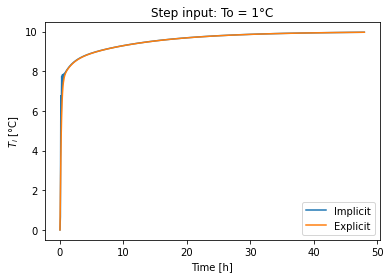

In [35]:
y_exp = Cs @ θ_exp + Ds @  u
y_imp = Cs @ θ_imp + Ds @  u

fig, ax = plt.subplots()
ax.plot(t / 3600, y_exp.T, t / 3600, y_imp.T)
ax.set(xlabel='Time [h]',
       ylabel='$T_i$ [°C]',
       title='Step input: To = 1°C')
ax.legend(['Implicit', 'Explicit'])
plt.show()

> Figure 5. Step response to outdoor temperature by using Euler [explicit](https://en.m.wikipedia.org/wiki/Numerical_methods_for_ordinary_differential_equations#Euler_method) and [implicit](https://en.m.wikipedia.org/wiki/Numerical_methods_for_ordinary_differential_equations#Backward_Euler_method) integration.

The value obtained after the [settling time](https://en.m.wikipedia.org/wiki/Settling_time) is almost equal to the values obtained in steady-state.

In [36]:
print('Steady-state indoor temperature obtained with:')
print(f'- DAE model: {float(θ[6]):.4f} °C')
print(f'- state-space model: {float(yss):.4f} °C')
print(f'- response to step input: {float(y_exp[:, -2]):.4f} °C')

Steady-state indoor temperature obtained with:
- DAE model: 10.0000 °C
- state-space model: 10.0000 °C
- response to step input: 9.9686 °C


### Simulation with weather data

#### Inputs
##### Read weather data
Dynamic simulation needs weather data for air temperature, direct radiation on a normal surface and diffuse radiation on an horizontal surface (see the tutorial on [Weather data and solar radiation](../t01/t01ReadWeatherData.ipynb)).

In [37]:
filename = 'FRA_Lyon.074810_IWEC.epw'
[data, meta] = dm4bem.read_epw(filename, coerce_year=None)
weather = data[["temp_air", "dir_n_rad", "dif_h_rad"]]
del data

##### Start and end time
The simulation will be done from `start_date` to `end_date` indicated in the format `2000-MM-DD HH:MM:SS`. The data are for a year (the choice of `2000` for the year is arbitrary).

In [38]:
start_date = '2000-01-03 12:00:00'
end_date = '2000-02-05 18:00:00'

print(f'{start_date} \tstart date')
print(f'{end_date} \tend date')

2000-01-03 12:00:00 	start date
2000-02-05 18:00:00 	end date


From the weather data, we sellect:
- hourly outdoor air temperature, °C;
- hourly solar [direct normal irradiance](https://en.m.wikipedia.org/wiki/Direct_insolation) (or beam radiation), W/m²;
- hourly solar diffuse horizontal irradiance (or diffuse sky radiation), W/m²,

from the start to the end date.

In [39]:
weather.index = weather.index.map(lambda t: t.replace(year=2000))
weather = weather[(weather.index >= start_date) & (
    weather.index < end_date)]

pd.DataFrame(weather)

,temp_air,dir_n_rad,dif_h_rad
2000-01-03 12:00:00+01:00,6.8,6,133
2000-01-03 13:00:00+01:00,8.0,74,150
2000-01-03 14:00:00+01:00,10.0,90,135
2000-01-03 15:00:00+01:00,9.0,64,84
2000-01-03 16:00:00+01:00,8.0,0,19
...,...,...,...
2000-02-05 13:00:00+01:00,11.0,696,99
2000-02-05 14:00:00+01:00,12.0,540,126
2000-02-05 15:00:00+01:00,12.0,383,109
2000-02-05 16:00:00+01:00,11.0,136,79


##### Solar irradiance on the walls
For the surface orientation given by `slope`, `azimuth`and `latitude`, from weather data, we may calculate the:
- direct irradiance,
- diffuse irradiance,
- reflected irradiance

for hourly solar [irradiance](https://en.m.wikipedia.org/wiki/Solar_irradiance) [W/m²] on a tilted surface.

In [40]:
surface_orientation = {'slope': 90,
                       'azimuth': 0,
                       'latitude': 45}
albedo = 0.2
rad_surf = dm4bem.sol_rad_tilt_surf(
    weather, surface_orientation, albedo)
pd.DataFrame(rad_surf)

,direct,diffuse,reflected
2000-01-03 12:00:00+01:00,5.423683,66.5,27.025936
2000-01-03 13:00:00+01:00,62.074669,75.0,34.289730
2000-01-03 14:00:00+01:00,66.175859,67.5,30.353167
2000-01-03 15:00:00+01:00,38.420856,42.0,17.456968
2000-01-03 16:00:00+01:00,0.000000,9.5,3.800000
...,...,...,...
2000-02-05 13:00:00+01:00,547.837791,49.5,73.778661
2000-02-05 14:00:00+01:00,366.835007,63.0,55.437685
2000-02-05 15:00:00+01:00,206.374750,54.5,32.485083
2000-02-05 16:00:00+01:00,51.032277,39.5,15.800272


Let's consider that the total solar [irradiance](https://en.m.wikipedia.org/wiki/Solar_irradiance)  $E_{tot}$ is the sum of direct, diffuse, and reflected components.  

In [41]:
rad_surf['Etot'] = rad_surf.sum(axis=1)

##### Resample the weather data
The weather data is at the time-step of 1h. It needs to be resampled at time step $\Delta t$ used for numerical integration.

In [42]:
data = pd.concat([weather['temp_air'], rad_surf['Etot']], axis=1)
data = data.resample(str(dt) + 'S').interpolate(method='linear')
data = data.rename(columns={'temp_air': 'To'})
pd.DataFrame(data)

,To,Etot
2000-01-03 12:00:00+01:00,6.800000,98.949619
2000-01-03 12:04:00+01:00,6.880000,103.777271
2000-01-03 12:08:00+01:00,6.960000,108.604923
2000-01-03 12:12:00+01:00,7.040000,113.432575
2000-01-03 12:16:00+01:00,7.120000,118.260227
...,...,...
2000-02-05 16:44:00+01:00,10.266667,34.515346
2000-02-05 16:48:00+01:00,10.200000,27.986510
2000-02-05 16:52:00+01:00,10.133333,21.457673
2000-02-05 16:56:00+01:00,10.066667,14.928837


##### Other inputs
Let's consider the indoor temperature setpoint $T_{i,sp} = 20 \, \mathrm{^\circ C}$ and auxiliary heat flow $\dot{Q}_a = 0 \, \mathrm{W}$ constant for the whole simulation period.

In [43]:
data['Ti'] = 20 * np.ones(data.shape[0])
data['Qa'] = 0 * np.ones(data.shape[0])
pd.DataFrame(data)

,To,Etot,Ti,Qa
2000-01-03 12:00:00+01:00,6.800000,98.949619,20.0,0.0
2000-01-03 12:04:00+01:00,6.880000,103.777271,20.0,0.0
2000-01-03 12:08:00+01:00,6.960000,108.604923,20.0,0.0
2000-01-03 12:12:00+01:00,7.040000,113.432575,20.0,0.0
2000-01-03 12:16:00+01:00,7.120000,118.260227,20.0,0.0
...,...,...,...,...
2000-02-05 16:44:00+01:00,10.266667,34.515346,20.0,0.0
2000-02-05 16:48:00+01:00,10.200000,27.986510,20.0,0.0
2000-02-05 16:52:00+01:00,10.133333,21.457673,20.0,0.0
2000-02-05 16:56:00+01:00,10.066667,14.928837,20.0,0.0


##### Input vector in time
The input is formed by the vectors of temperature sources in time $\left [ T_o, T_o ,T_o, T_{i,sp} \right ]^T$ and vectors of the heat flow sources in time $\left [ \Phi_o, \Phi_i, \dot{Q_a}, \Phi_a \right ]^T$:

$$u = 
\begin{bmatrix}
T_o\\ 
T_o\\ 
T_o\\ 
T_{i,sp}\\ 
\Phi_o\\ 
\Phi_i\\ 
\dot{Q}_a\\ 
\Phi_a
\end{bmatrix}
= \begin{bmatrix}
T_{o(0)} & T_{o(1)}& ... & T_{o(n-1)}\\ 
T_{o(0)} & T_{o(1)}& ... & T_{o(n-1)}\ \\ 
T_{o(0)} & T_{o(1)}& ... & T_{o(n-1)}\ \\ 
 T_{i,sp(0)} & T_{i,sp(1)}& ... & T_{i,sp(n-1)}\ \\ 
\Phi_{o,(0)} & \Phi_{o,(1)} & ... & \Phi_{o,(n-1)}\\
\Phi_{i,(0)} & \Phi_{i,(1)} & ... & \Phi_{i,(n-1)}\\ 
 \dot{Q}_{a(0)} & \dot{Q}_{a(1)} & ... & \dot{Q}_{a(n-1)}\\ 
\Phi_{a,(0)} & \Phi_{a,(1)} & ... & \Phi_{a,(n-1)}
\end{bmatrix}$$

where:

$T_o$: time vector of outdoor temperatures (from weather data), °C.

$T_{i,sp}$: time vector of indoor set-point temperatures, °C.

$\Phi_o$: time vector of radiation, in W, absorbed by the outdoor surface of the wall:

$$\Phi_o = \alpha_{w,SW} S_w E_{tot}$$

where:
- $\alpha_{w,SW}$ is the absortion coefficient of the outdoor surface of the wall in short wave, $0 \leqslant \alpha_{w,SW} \leqslant 1$;
- $S_w$ - surface area of the wall, m²;
- $E_{tot}$ - total solar irradiation on the wall, W/m².

$\Phi_i$: time vector of radiation, in W, absorbed by the indoor surfaces of the wall:

$$\Phi_i = \tau_{g,SW}  \alpha_{w,SW} S_g E_{tot}$$

where:
- $\tau_{g,SW}$ is the transmission coefficient of the window glass, $0 \leqslant \tau_{g,SW} \leqslant 1$;
- $\alpha_{w,SW}$ - absortion coefficient of the indoor surface of the wall in short wave, $0 \leqslant \alpha_{w,SW} \leqslant 1$;
- $S_g$ - surface area of the window glass, m²;
- $E_{tot}$ - total solar radiation intensity on the wall, W/m².

$\dot{Q}_a$: time vector of auxiliary heat flows (from occupants, electrical devices, etc.), W.

$\Phi_a$: vector of radiation,, in W, absorbed by the window glass:

$$\Phi_a = \alpha_{g,SW} S_g E_{tot}$$

where:
- $\alpha_{g,SW}$ is the absortion coefficient of the glass window in short wave, $0 \leqslant \alpha_{w,SW} \leqslant 1$;
- $S_g$ - surface area of the glass window, m²;
- $E_{tot}$ - total solar irradiation on the wall, W/m².

In [44]:
To = data['To']
Ti = data['Ti']
Φo = α_wSW * wall['Surface']['Concrete'] * data['Etot']
Φi = τ_gSW * α_wSW * wall['Surface']['Glass'] * data['Etot']
Qa = data['Qa']
Φa = α_gSW * wall['Surface']['Glass'] * data['Etot']

u = pd.concat([To, To, To, Ti, Φo, Φi, Qa, Φa], axis=1)
u.columns.values[[4, 5, 7]] = ['Φo', 'Φi', 'Φa']
pd.DataFrame(u)

,To,To,To,Ti,Φo,Φi,Qa,Φa
2000-01-03 12:00:00+01:00,6.800000,6.800000,6.800000,20.0,1113.183215,66.790993,0.0,338.407697
2000-01-03 12:04:00+01:00,6.880000,6.880000,6.880000,20.0,1167.494300,70.049658,0.0,354.918267
2000-01-03 12:08:00+01:00,6.960000,6.960000,6.960000,20.0,1221.805385,73.308323,0.0,371.428837
2000-01-03 12:12:00+01:00,7.040000,7.040000,7.040000,20.0,1276.116470,76.566988,0.0,387.939407
2000-01-03 12:16:00+01:00,7.120000,7.120000,7.120000,20.0,1330.427555,79.825653,0.0,404.449977
...,...,...,...,...,...,...,...,...
2000-02-05 16:44:00+01:00,10.266667,10.266667,10.266667,20.0,388.297648,23.297859,0.0,118.042485
2000-02-05 16:48:00+01:00,10.200000,10.200000,10.200000,20.0,314.848236,18.890894,0.0,95.713864
2000-02-05 16:52:00+01:00,10.133333,10.133333,10.133333,20.0,241.398824,14.483929,0.0,73.385242
2000-02-05 16:56:00+01:00,10.066667,10.066667,10.066667,20.0,167.949412,10.076965,0.0,51.056621


#### Initial conditions
The initial value of the state-vector can be zero or different from zero.

In [45]:
θ_exp = 20 * np.ones([As.shape[0], u.shape[0]])

#### Time integration
[Explicit Euler](https://en.m.wikipedia.org/wiki/Numerical_methods_for_ordinary_differential_equations#Euler_method) integration in time,

$$ \theta_{s,k+1} = (I + \Delta t A) \theta_{s,k} + \Delta t B u_k $$

where $k = 0, ... , n - 1$,

In [46]:
for k in range(u.shape[0] - 1):
    θ_exp[:, k + 1] = (I + dt * As) @ θ_exp[:, k]\
        + dt * Bs @ u.iloc[k, :]

yields the time variation of state variable $\theta$, from which we obtain the variation of the output (i.e. indoor temperature):

$$y = C_s \theta_s + D_s u$$

and the variation of the heat flow of the HVAC system:

$$q_{HVAC} = K_p (T_{i,sp} - \theta_i) = K_p (T_{i,sp} - y)$$

where $K_p$ is the gain of the P-controller and $T_{i,sp}$ is the HVAC-setpoint for the indoor temperature.

In [47]:
y_exp = Cs @ θ_exp + Ds @ u.to_numpy().T
q_HVAC = Kp * (data['Ti'] - y_exp[0, :])

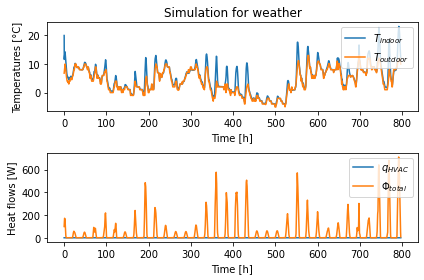

In [48]:
t = dt * np.arange(data.shape[0])   # time vector

fig, axs = plt.subplots(2, 1)
# plot indoor and outdoor temperature
axs[0].plot(t / 3600, y_exp[0, :], label='$T_{indoor}$')
axs[0].plot(t / 3600, data['To'], label='$T_{outdoor}$')
axs[0].set(xlabel='Time [h]',
           ylabel='Temperatures [°C]',
           title='Simulation for weather')
axs[0].legend(loc='upper right')

# plot total solar radiation and HVAC heat flow
axs[1].plot(t / 3600,  q_HVAC, label='$q_{HVAC}$')
axs[1].plot(t / 3600, data['Etot'], label='$Φ_{total}$')
axs[1].set(xlabel='Time [h]',
           ylabel='Heat flows [W]')
axs[1].legend(loc='upper right')

fig.tight_layout()

> Figure 6. Simulation with weather data using Euler explicit method of integration. a) Indoor and outdoor temperatures. b) Solar and HVAC heat flow rates.

## Discussion

The time step depends on:

- P-controller gain `Kp`:
    - if $K_p \rightarrow \infty$, then the controller is perfect and the time step needs to be small;
    - if $K_p \rightarrow 0$, then, the controller is inefffective and the building is in free-running.
- Capacities considered into the model:
    - if the capacities of the air $C_a =$ `C['Air']` and $C_g =$ `C['Glass']` are considered, then the time step is small;
    - if the capacities of the air and of the glas are zero, then the time step is large (and the order of the state-space model is reduced).

The controller models an HVAC system able to heat (when $q_{HVAC} > 0$) and to cool $q_{HVAC} < 0$).

**References**

1. C. Ghiaus (2013) Causality issue in the heat balance method for calculating the design heating and cooling loads, *Energy* 50: 292-301, https://doi.org/10.1016/j.energy.2012.10.024

2. J.A. Duffie, W. A. Beckman, N. Blair (2020) Solar Engineering of Thermal Processes, 5th ed. John Wiley & Sons, Inc. ISBN 9781119540281

3. CSTB (2005) Réglementation Thermique 2005. Méthode de calcul Th-CE. Annexe à l’arrêté du 19 juillet 2006